In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Dict

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from torch_sparse import SparseTensor
from jaxtyping import Float, Integer
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import os

from src.graph_models.csbm import CSBM
from src.models.common import get_diffusion
from src.models.ntk import NTK
from src.attacks import create_attack
from common import configure_hardware, get_graph, \
    count_edges_for_idx, calc_kernel_means, plot_ntk_model_diff, plot_ntk_model_acc
from src import utils

In [4]:
# Data
data_dict = dict(
    classes = 2,
    n = 1000,
    n_per_class_trn = 300,
    n_per_class_labeled = 300,
    sigma = 1,
    avg_within_class_degree = 1.58 * 2,
    avg_between_class_degree = 0.37 * 2,
)
K = 1
seed = 1
# Model
model_dict_gcn = {
    "label": "GCN",
    "model": "GCN",
    "normalization": "row_normalization",
    "depth": 1,
}
model_dict_softmedoid = {
    "label": "SoftM_T1",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 1
}
model_dict_softmedoid5 = {
    "label": "SoftM_T5",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 5
}
model_dict = model_dict_gcn
model_dict_l = [model_dict_gcn, model_dict_softmedoid, model_dict_softmedoid5]
attack_params = {
    "attack": "prbcd",
    "search_space_size": 50_000,
    "epochs": 100,
    "fine_tune_epochs": 0
}
# Attack
eps_l = [0, 0.05, 0.10, 0.25]
# other
device = "0"
dtype = torch.float64

In [5]:
rng = np.random.Generator(np.random.PCG64(seed))
ntk_dict = dict()
device_ = configure_hardware(device, seed)
data_dict["K"] = K
# Sample
X, A, y = get_graph(data_dict, seed=seed, sort=True)
X = torch.tensor(X, dtype=dtype, device=device_)
A = torch.tensor(A, dtype=dtype, device=device_)
y = torch.tensor(y, device=device_)
# Trn / Test Split
n_cls0 = sum(y == 0).cpu().item()
n = len(y)
idx_cls0 = rng.permutation(np.arange(n_cls0))
idx_cls1 = rng.permutation(np.arange(n_cls0, n))
n_trn = data_dict["n_per_class_trn"]
n_labeled = data_dict["n_per_class_labeled"]
idx_labeled = np.concatenate((idx_cls0[:n_labeled], idx_cls1[:n_labeled]))
idx_unlabeled = np.concatenate((idx_cls0[n_labeled:], idx_cls1[n_labeled:]))
idx_target = np.concatenate((idx_cls0[n_trn:], idx_cls1[n_trn:]))
for model_dict in model_dict_l:
    # Init Attack
    ntk = NTK(model_dict, device=device_)
    attack = create_attack(idx_target, X, A, y, idx_labeled, idx_unlabeled, 
                           attack_params, seed, ntk, device=device_)
    # Computing NTK
    ntk_l = list()
    acc_l = list()
    for eps in eps_l:
        n_pert = int(round(eps * count_edges_for_idx(A.cpu(), idx_target)))
        A_pert = attack.attack(n_pert).detach().clone()
        ntk_pert = NTK(model_dict, X, A_pert)
        y_pred = ntk_pert(idx_labeled, idx_unlabeled, y)
        acc_l.append(utils.accuracy(y_pred, y[idx_target]).cpu().item())
        ntk_l.append(ntk_pert)
    ntk_dict[model_dict["label"]] = ntk_l
    ntk_dict[model_dict["label"]+"_acc"] = acc_l

100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


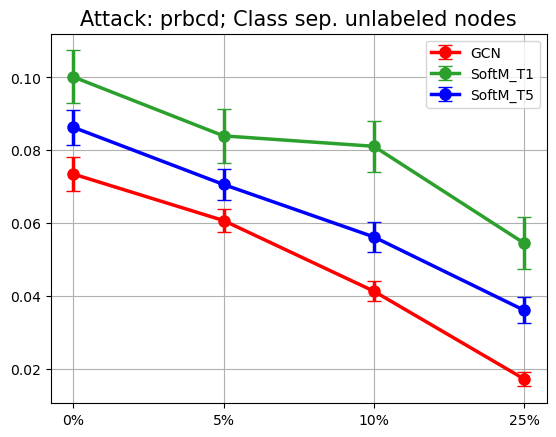

In [18]:
plot_ntk_model_diff(ntk_dict, y, eps_l, idx_use=idx_unlabeled, plot_title=attack_params["attack"]+"; Class sep. unlabeled nodes")

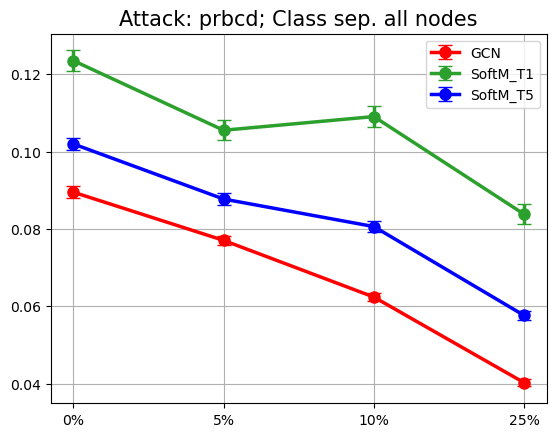

In [16]:
plot_ntk_model_diff(ntk_dict, y, eps_l, plot_title=attack_params["attack"]+"; Class sep. all nodes")

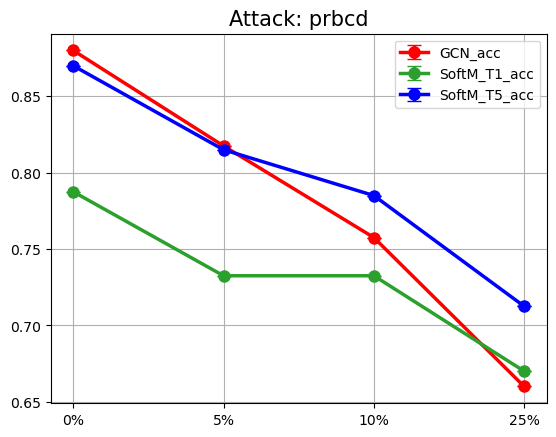

In [7]:
plot_ntk_model_acc(ntk_dict, y, eps_l, attack_params["attack"])

In [14]:
# Data
data_dict = dict(
    classes = 2,
    n = 1000,
    n_per_class_trn = 300,
    n_per_class_labeled = 300,
    sigma = 1,
    avg_within_class_degree = 1.58 * 2,
    avg_between_class_degree = 0.37 * 2,
)
K = 1
seed = 1
# Model
model_dict_softmedoid05 = {
    "label": "SoftM_T0.5",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 0.5
}
model_dict_softmedoid1 = {
    "label": "SoftM_T1",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 1
}
model_dict_softmedoid2 = {
    "label": "SoftM_T2.5",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 2.5
}
model_dict_softmedoid5 = {
    "label": "SoftM_T5",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 5
}
model_dict_softmedoid10 = {
    "label": "SoftM_T10",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 10
}
model_dict = model_dict_gcn
model_dict_l = [model_dict_softmedoid05, model_dict_softmedoid1, model_dict_softmedoid2, model_dict_softmedoid5, model_dict_softmedoid10]
attack_params = {
    "attack": "prbcd",
    "search_space_size": 50_000,
    "epochs": 100,
    "fine_tune_epochs": 0
}
# Attack
eps_l = [0, 0.05, 0.10, 0.25]
# other
device = "0"
dtype = torch.float64

In [15]:
rng = np.random.Generator(np.random.PCG64(seed))
ntk_dict = dict()
device_ = configure_hardware(device, seed)
data_dict["K"] = K
# Sample
X, A, y = get_graph(data_dict, seed=seed, sort=True)
X = torch.tensor(X, dtype=dtype, device=device_)
A = torch.tensor(A, dtype=dtype, device=device_)
y = torch.tensor(y, device=device_)
# Trn / Test Split
n_cls0 = sum(y == 0).cpu().item()
n = len(y)
idx_cls0 = rng.permutation(np.arange(n_cls0))
idx_cls1 = rng.permutation(np.arange(n_cls0, n))
n_trn = data_dict["n_per_class_trn"]
n_labeled = data_dict["n_per_class_labeled"]
idx_labeled = np.concatenate((idx_cls0[:n_labeled], idx_cls1[:n_labeled]))
idx_unlabeled = np.concatenate((idx_cls0[n_labeled:], idx_cls1[n_labeled:]))
idx_target = np.concatenate((idx_cls0[n_trn:], idx_cls1[n_trn:]))
for model_dict in model_dict_l:
    # Init Attack
    ntk = NTK(model_dict, device=device_)
    attack = create_attack(idx_target, X, A, y, idx_labeled, idx_unlabeled, 
                           attack_params, seed, ntk, device=device_)
    # Computing NTK
    ntk_l = list()
    acc_l = list()
    for eps in eps_l:
        n_pert = int(round(eps * count_edges_for_idx(A.cpu(), idx_target)))
        A_pert = attack.attack(n_pert).detach().clone()
        ntk_pert = NTK(model_dict, X, A_pert)
        y_pred = ntk_pert(idx_labeled, idx_unlabeled, y)
        acc_l.append(utils.accuracy(y_pred, y[idx_target]).cpu().item())
        ntk_l.append(ntk_pert)
    ntk_dict[model_dict["label"]] = ntk_l
    ntk_dict[model_dict["label"]+"_acc"] = acc_l

100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


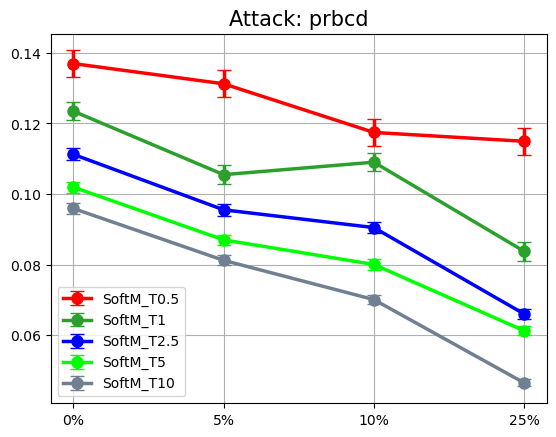

In [16]:
plot_ntk_model_diff(ntk_dict, y, eps_l, attack_params["attack"])

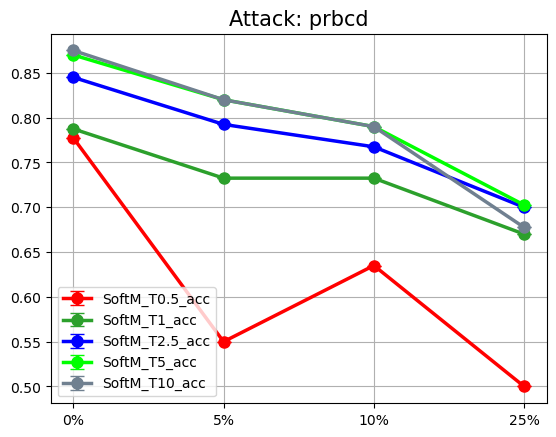

In [17]:
plot_ntk_model_acc(ntk_dict, y, eps_l, attack_params["attack"])

In [36]:
t_grad

tensor(indices=tensor([[1, 1],
                       [0, 1]]),
       values=tensor([1., 2.]),
       size=(2, 2), nnz=2, layout=torch.sparse_coo, requires_grad=True)

In [37]:
ind = t.to_sparse(sparse_dim=2).indices()
weight = t.to_sparse(sparse_dim=2).values()
weight.requires_grad = True

In [39]:
t = torch.sparse_coo_tensor(*(ind, weight), 2*[2])

In [41]:
t.to_dense()

tensor([[0., 0.],
        [1., 2.]], grad_fn=<ToDenseBackward0>)